In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
import pymc as pm
from properscoring import crps_ensemble
import random
from patsy import dmatrix
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import nbinom

from joblib import Parallel, delayed
from tqdm import tqdm

sys.path.append(os.path.abspath('../src'))
project_dir = Path.cwd().parent

from data_tools.data_utils import SeroDataset, PartialCountDataset, TrueCountDataset
from model_tools.train_utils import BaseTrain, SparsePropTrain, SeroTrain
from model_tools.models import NowcastPNN, PropPNN, SparsePropPNN, SeroPNN
from model_tools.evaluation import eval_pnn, eval_prop_pnn, eval_sparse_prop_pnn, eval_sero_pnn, plot_pnn_preds, plot_prop_pnn_preds, plot_sero_pnn_preds

M = 50
D = 40
S = 500


start_year = 2022
end_year = 2022
seed = 123

# 123, 2019, 2023, 15

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M, norm=False)
true_count_dataset = TrueCountDataset(delays_df)

class PropBNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        window_dates = [date - pd.Timedelta(days=i) for i in range(M)]
        window_dates = sorted(window_dates)
        Z_obs = self.partial_count_obj.get_obs(date)
        y_true = [self.true_count_obj.get_y(day) for day in window_dates]
        y_true = np.array(y_true).reshape(M)
        dow = date.day_of_week
        return Z_obs, y_true, window_dates

set_seed(seed)

# End of 2023 appears to have some incomplete data
if end_year == 2023:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-25", freq='D'))
else:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-31", freq='D'))

T = len(dates)
# T = 8
    
dataset = PropBNNDataset(partial_count_dataset, true_count_dataset, dates)


def silu(x):
    return x * pm.math.sigmoid(x)


def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        cores=1,
        init="adapt_diag",
        chains=1,
        draws=S,
        tune=500,
        target_accept=0.95,
        max_treedepth=10,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"}
    )

def get_mask(D):
        mask_matrix = np.ones(shape=(D, D), dtype=bool)
        for i in range(D):
            for j in range(D):
                if i + j > D - 1:
                    mask_matrix[i, j] = False
        return mask_matrix

def create_fourier_features(t, n, p=10.0):
    x = 2 * np.pi * (np.arange(n) + 1) * t[:, None] / p
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)


In [2]:
# Constants
t = np.arange(0, M)
t_week = t % 7
t_norm = t / M

n = 14
fourier_basis_biweek = create_fourier_features(t, n=n, p=3.5)
fourier_basis_week = create_fourier_features(t, n=n, p=7)

fourier_basis_biweek = fourier_basis_biweek - fourier_basis_biweek.mean(0, keepdims=True)
fourier_basis_week = fourier_basis_week - fourier_basis_week.mean(0, keepdims=True)

spline_trend = dmatrix(
    "bs(t, df=14, degree=3, include_intercept=False)", {"t": t_norm}, return_type='dataframe'
)
X_trend = np.asarray(spline_trend)

spline_week = dmatrix(
    "cc(t_week, df=7)", {"t_week": t_week}, return_type='dataframe'
)
X_week = np.asarray(spline_week)

t_input = np.arange(M)[:, None] / M
time_input = np.concatenate([t_input, fourier_basis_biweek, fourier_basis_week], axis=1)

mask = np.ones((M,D), dtype=bool)
mask[-D:,:] = get_mask(D)




In [3]:
def run_PropBNN(Z_obs, Z_norm):
    with pm.Model() as PropBNN:
        log_const = pm.Normal("const", sigma=10)
    

        # Trend spline coefficients
        sigma_trend = pm.HalfNormal("sigma_trend", 10)
        beta_trend = pm.Normal("beta_trend", mu=0, sigma=sigma_trend, shape=X_trend.shape[1])
        
        # Cyclic spline coefficients (seasonality)
        sigma_week = pm.HalfNormal("sigma_week", 10)
        beta_week = pm.Normal("beta_week", mu=0, sigma=sigma_week, shape=X_week.shape[1])
        
        # GRW for prediction intervals
        init_dist = pm.Normal.dist(mu=0, sigma=10)
        sigma_rw = pm.HalfNormal("sigma_rw", 3)
        rw = pm.GaussianRandomWalk("log_lambda", sigma=sigma_rw, shape=M, init_dist=init_dist)

        # Create lam param 
        log_lam = pm.Deterministic(
                "log_lam", rw + pm.math.dot(X_trend, beta_trend) + pm.math.dot(X_week, beta_week)
            )
        lam = pm.Deterministic("lam", pm.math.exp(log_const + log_lam))

        # NN for proportions from time inputs
        n_hidden = 16
        net_sd = 0.15
        
        W1 = pm.Normal("W1", 0, net_sd, shape=(1+4*n, n_hidden))
        b1 = pm.Normal("b1", 0, net_sd, shape=(n_hidden,))
        h1 = silu(pm.math.dot(time_input, W1) + b1)

        Wz = pm.Normal("Wz", 0, net_sd, shape=(D, n_hidden))
        bz = pm.Normal("bz", 0, net_sd, shape=(n_hidden,))
        hz = silu(pm.math.dot(Z_norm, Wz) + bz)
        h1 = hz + h1
        
        # ----- Output layer: hidden → delay bins -----
        W2 = pm.Normal("W2", 0, net_sd, shape=(n_hidden, D))
        b2 = pm.Normal("b2", 0, net_sd, shape=(D,))
        p_raw = pm.math.dot(h1, W2) + b2 
        p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=1))


        # Make mu param per tim/delay point
        log_mu = pm.math.log(lam[:, None]) + pm.math.log(p + 1e-6)
        mu = pm.Deterministic("mu", pm.math.exp(log_mu))

        # Overdispersion per time point
        sigma_theta = pm.HalfNormal("sigma_theta", 3)
        theta = pm.Exponential("theta", lam=1/sigma_theta, shape=(M,1))
        theta_broadcast = np.repeat(theta, D, axis=1)

        # Observed data
        z = pm.NegativeBinomial("z", mu[mask], theta_broadcast[mask], observed=Z_obs[mask])
        idata = pm.sample(progressbar=True, **sampler_kwargs())
    return idata

In [4]:
def run_single(idx):
    Z_obs, _, _ = dataset.__getitem__(idx)
    Z_norm = Z_obs / (Z_obs.max() + 1e-6)
    idata = run_PropBNN(Z_obs, Z_norm)
    mu_samples = az.extract(idata, group='posterior')['mu']
    theta_samples = az.extract(idata, group='posterior')['theta']
    return mu_samples, theta_samples
    

mu_samples = np.zeros((T, M, D, S))
theta_samples = np.zeros((T, M,1,S ))
results = Parallel(n_jobs=4)(
    delayed(run_single)(idx) for idx in tqdm(range(T))
)


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [01:19<00:00,  9.88s/it]


In [5]:
for idx, (mu, theta) in enumerate(results):
    mu_samples[idx, :, :, :] = mu
    theta_samples[idx, :, :, :] = theta

In [6]:
np.savez_compressed(project_dir / "src" / "outputs" / "PropBNN" / 'mu_samples.npz',
                    mu=mu_samples.reshape(mu_samples.shape[0], -1))

np.savez_compressed(project_dir / "src" / "outputs" / "PropBNN" / 'theta_samples.npz',
                    theta=theta_samples.reshape(theta_samples.shape[0], -1))

In [12]:
# mu_samples = np.loadtxt(project_dir / "src" / "outputs" / "PropBNN" / 'mu_samples.npz', delimiter=",")
# mu_samples = mu_samples.reshape((T, M, D, S))

# theta_samples = np.loadtxt(project_dir / "src" / "outputs" / "PropBNN" / 'theta_samples.npz', delimiter=",")
# theta_samples = theta_samples.reshape((T, M, 1, S))

data = np.load(project_dir / "src" / "outputs" / "PropBNN" / "mu_samples.npz")
mu_samples = data['mu'].reshape((T, M, D, S))

data = np.load(project_dir / "src" / "outputs" / "PropBNN" / "theta_samples.npz")
mtheta_samples = data['theta'].reshape((T, M, 1, S))

In [13]:
mu_samples.shape

(8, 50, 40, 500)

In [14]:
r = np.broadcast_to(theta_samples, mu_samples.shape)
mu = mu_samples
p = r / (r + mu)

z_samples = np.random.negative_binomial(r, p, size=mu_samples.shape)
z_samples.shape

(8, 50, 40, 500)

In [15]:
y_pred = z_samples[:, -1, :, :].sum(1)
y_pred.shape

(8, 500)

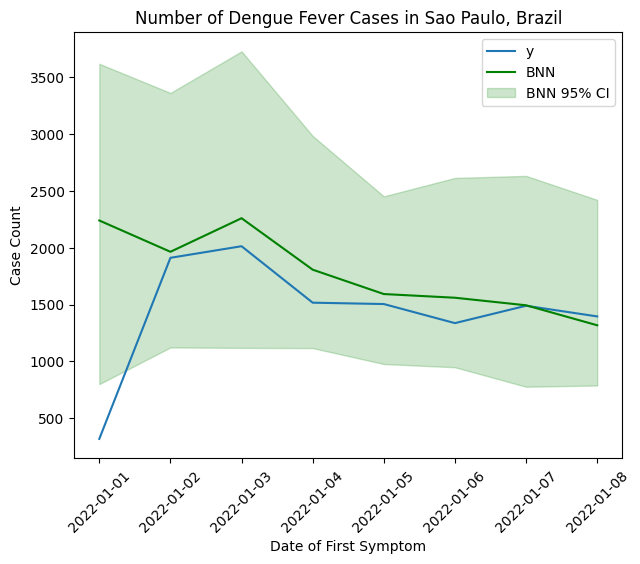

In [16]:

y_true = [dataset.__getitem__(idx)[1][-1] for idx in range(T)]
window_dates = [dataset.__getitem__(idx)[2][-1] for idx in range(T)]

y_pred_med = np.quantile(y_pred, 0.5, axis=1)
y_pred_lower = np.quantile(y_pred, 0.025, axis=1)
y_pred_upper = np.quantile(y_pred, 0.975, axis=1)

plt.plot(window_dates, y_true, label='y')

plt.plot(window_dates, y_pred_med, label='BNN', color='green')
plt.fill_between(window_dates, y_pred_lower, y_pred_upper, color='green', alpha=0.2, label='BNN 95% CI')


plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.xticks(rotation=45)
plt.show()



In [17]:
def compute_pica(y_true, y_pred, alpha=0.05):

    lower = np.quantile(y_pred, alpha / 2, axis=1)
    upper = np.quantile(y_pred, 1 - alpha / 2, axis=1)
    within_interval = (y_true >= lower) & (y_true <= upper)
    empirical_coverage = np.mean(within_interval)
    expected_coverage = 1 - alpha
    return np.abs(empirical_coverage - expected_coverage)

def nb_pmf(y, mu, theta):
    # Convert mean/dispersion to n,p parameters
    n = theta
    p = theta / (theta + mu)
    return nbinom.pmf(y, n, p)

import numpy as np

def nb_pmf(k, mu, theta):
    # Negative Binomial PMF (mean mu, overdispersion theta)
    from scipy.special import gammaln
    r = theta
    p = r / (r + mu)
    return np.exp(
        gammaln(k + r) - gammaln(r) - gammaln(k + 1) +
        r * np.log(p) + k * np.log(1 - p)
    )

def compute_elpd(y_true, mu_samples, theta_samples):
    # y_true: shape (T, D)
    # mu_samples: shape (T, D, S)
    # theta_samples: shape (T, S)
    T, D, S = mu_samples.shape
    elpd = 0.0

    for i in range(T):
        log_p_s = np.zeros(S)
        for s in range(S):
            # theta shared across D for time i, sample s
            theta_is = theta_samples[i, s]

            # compute log pmf for each d and sum
            log_p_s[s] = np.sum(np.log(
                nb_pmf(y_true[i], mu_samples[i, :, s], theta_is) + 1e-12
            ))

        max_log = np.max(log_p_s)
        elpd += max_log + np.log(np.mean(np.exp(log_p_s - max_log)))  # log-sum-exp trick

    return elpd





In [18]:
mu = mu_samples[:, -1, :, :]
theta = theta_samples[:, -1, 0, :]

In [19]:
crps_ensemble(y_true, y_pred).mean()

307.8859914999998

In [20]:
compute_elpd(y_true, mu, theta)

-6766.400067683046